In [1]:
%matplotlib inline

import os
import sys
import time
import pandas as pd
import numpy as np
import graphviz
from sklearn import metrics
from sklearn import tree
from scipy.stats import entropy
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
src_path = '{}/src'.format(module_path)
if module_path not in sys.path:
    sys.path.append(src_path)

from algorithms import simple_matching
plt.rcParams.update({'figure.max_open_warning': 0})

## Carregando base e transformando colunas em categórico

In [2]:
ndp_path = '{}/data/processed/d_dataset_ndp.csv'.format(module_path)
dp_path = '{}/data/processed/d_dataset_dp.csv'.format(module_path)

df_ndp = pd.read_csv(ndp_path)
df_dp = pd.read_csv(dp_path)

# Transformando em categórico
df_ndp = df_ndp.astype('category')

## Execução do KModes

In [3]:
k = 7
km = KModes(n_clusters=k, init='Huang', n_init=10, random_state=1, verbose=0)
labels = km.fit_predict(df_ndp)

# Classificações em cada cluster
cluster = [ { 'class': None, 'size': 0, 'dp': 0, 'ndp': 0, 'entropy': 0 , 'purity': 0}  for _ in range(k) ]
for instance, label in enumerate(labels):
    cluster[label]['size'] += 1

    if df_dp.iloc[instance].Diagnosticado_Depressao == 1:
        cluster[label]['dp'] += 1
    else:
        cluster[label]['ndp'] += 1

n_total_itens = 0
pureza = 0

for i, cl in enumerate(cluster):
    if cl['dp'] > cl['ndp']:
        cl['class'] = 'dp'
        cl['purity'] = cl['dp'] / cl['size']
    else:
        cl['class'] = 'ndp'
        cl['purity'] = cl['ndp'] / cl['size']
    cl['entropy'] = entropy([ cl['dp'] / cl['size'], 
                             cl['ndp'] / cl['size']
                            ])
    n_total_itens += cl['size']
    print("Pureza do cluster [{}]: {}".format(i, cl['purity']))
    pureza += cl['purity']
pureza /= k

print('\n')

entropy_clustering = 0
for i, cl in enumerate(cluster):
    print("Entropia do cluster [{}]: {}".format(i, cl['entropy']))
    entropy_clustering += cl['entropy'] * (cl['size']/n_total_itens)

print('\n')    

print("Custo: {}".format(km.cost_))
print("Entropia Clusterização: {}".format(entropy_clustering))
print("Média da Pureza: {}".format(pureza))
print("Silhouette Index: {}".format(metrics.silhouette_score(df_ndp, labels, metric=simple_matching)))

Pureza do cluster [0]: 0.524873828406633
Pureza do cluster [1]: 0.815625
Pureza do cluster [2]: 0.6521460602178091
Pureza do cluster [3]: 0.8756613756613757
Pureza do cluster [4]: 0.6508379888268156
Pureza do cluster [5]: 0.6808510638297872
Pureza do cluster [6]: 0.6270833333333333


Entropia do cluster [0]: 0.691909254976447
Entropia do cluster [1]: 0.4779630723510834
Entropia do cluster [2]: 0.646108011878287
Entropia do cluster [3]: 0.3754811809894803
Entropia do cluster [4]: 0.6469263471727789
Entropia do cluster [5]: 0.6262262845584756
Entropia do cluster [6]: 0.6604897519542142


Custo: 14934.0
Entropia Clusterização: 0.6269460832648127
Média da Pureza: 0.6895826643251076
Silhouette Index: -0.28430738739679456


## ===== DAQUI PRA CIMA NINGUEM MEXE =====

In [3]:
disorder = 0.6
accuracy = 0.7

k = 5
km = KModes(n_clusters=k, init='Huang', n_init=10, random_state=1, verbose=0, n_jobs=-1)
labels = km.fit_predict(df_ndp)

# Classificações em cada cluster
cluster = [ { 'class': None, 'size': 0, 'dp': 0, 'ndp': 0, 'entropy': 0 , 'purity': 0}  for _ in range(k) ]
for instance, label in enumerate(labels):
    cluster[label]['size'] += 1

    if df_dp.iloc[instance].Diagnosticado_Depressao == 1:
        cluster[label]['dp'] += 1
    else:
        cluster[label]['ndp'] += 1

n_total_itens = 0
pureza = 0

for i, cl in enumerate(cluster):
    if cl['dp'] > cl['ndp']:
        cl['class'] = 'dp'
        cl['purity'] = cl['dp'] / cl['size']
    else:
        cl['class'] = 'dp'
        cl['purity'] = cl['ndp'] / cl['size']
    cl['entropy'] = entropy([ cl['dp'] / cl['size'], 
                             cl['ndp'] / cl['size']
                            ])
    n_total_itens += cl['size']
    print("Pureza do cluster [{}]: {}".format(i, cl['purity']))
    pureza += cl['purity']
pureza /= k

print('\n')

relevant_clusters = []
entropy_clustering = 0
for i, cl in enumerate(cluster):
    print("Entropia do cluster [{}]: {}".format(i, cl['entropy']))
    entropy_clustering += cl['entropy'] * (cl['size']/n_total_itens)
    if cl['entropy'] <= disorder and cl['purity'] >= accuracy:
        relevant_clusters.append(i)

print('\n')    

print("Custo: {}".format(km.cost_))
print("Média da Pureza: {}".format(pureza))
print("Entropia Clusterização: {}".format(entropy_clustering))
print("Silhouette Index: {}".format(metrics.silhouette_score(df_ndp, labels, metric=simple_matching)))

Pureza do cluster [0]: 0.5351724137931034
Pureza do cluster [1]: 0.5833333333333334
Pureza do cluster [2]: 0.5708920187793427
Pureza do cluster [3]: 0.8895833333333333
Pureza do cluster [4]: 0.7304964539007093


Entropia do cluster [0]: 0.6906709385752596
Entropia do cluster [1]: 0.6791932659915256
Entropia do cluster [2]: 0.6830618735669235
Entropia do cluster [3]: 0.3473855933459259
Entropia do cluster [4]: 0.5827644303976354


Custo: 15718.0
Média da Pureza: 0.6618955106279645
Entropia Clusterização: 0.6293702746003259
Silhouette Index: -0.2775679221876393


## Cria Dataframes dos Clusters relevantes

In [8]:
instances = { k: [] for k in relevant_clusters }
for i, label in enumerate(labels):
    if label in relevant_clusters:
        instances[label].append(i)

dfx = []
# target = []
for i in relevant_clusters:
    dfx.append(df_dp.iloc[instances[i]].copy())
    # target.append(df_dp.iloc[instances[i]].Diagnosticado_Depressao.copy())
    
for i, df_ in enumerate(dfx):
    df_.to_csv('{}/data/processed/cluster{}.csv'.format(module_path, i), header=True, index=False)

## Árvore de Decisão com os Clusters relevantes

In [6]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(dfx[0], target[0])
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("cluster3") 

'cluster3.pdf'

## Análise dos clusters gerados

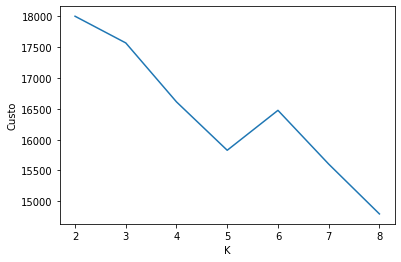

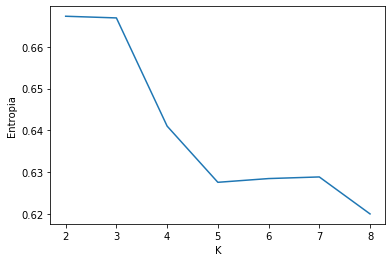

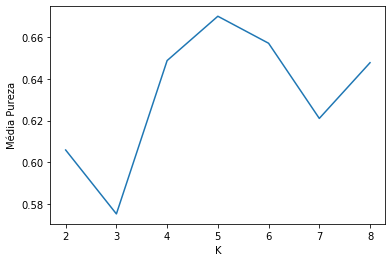

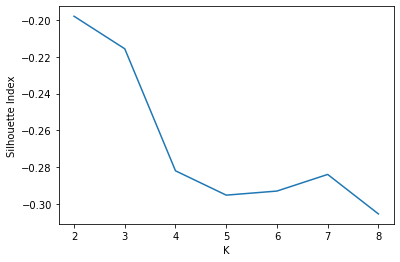

In [5]:
min_ = 2
max_ = 9

x = [i for i in range(min_, max_)] # valores de k
y = [] # Custos para cada valor de k
z = [] # Entropia para cada valor de k
w = [] # Pureza média para cada valor de k
r = [] # Silhouette Index para cada valor k

for k in x:
    km = KModes(n_clusters=k, init='Huang', random_state=1, verbose=0, n_jobs=-1)
    labels = km.fit_predict(df_ndp)
    centroids = km.cluster_centroids_
    y.append(km.cost_)

    # Classificações em cada cluster
    cluster = [ { 'class': None, 'size': 0, 'dp': 0, 'ndp': 0, 'entropy': 0 , 'purity': 0}  for _ in range(k) ]
    for instance, label in enumerate(labels):
        cluster[label]['size'] += 1

        if df_dp.iloc[instance].Diagnosticado_Depressao == 1:
            cluster[label]['dp'] += 1
        else:
            cluster[label]['ndp'] += 1

    # Classificar cada cluster de acordo com sua classe mais relevante
    n_total_itens = 0
    pureza = 0

    for cl in cluster:
        if cl['dp'] > cl['ndp']:
            cl['class'] = 'dp'
            cl['purity'] = cl['dp'] / cl['size']
        else:
            cl['class'] = 'ndp'
            cl['purity'] = cl['ndp'] / cl['size']
        cl['entropy'] = entropy([ cl['dp'] / cl['size'], 
                                 cl['ndp'] / cl['size']
                                ])
        n_total_itens += cl['size']
        pureza += cl['purity']
    pureza /= k
    
    w.append(pureza)

    # Verificar a acurácia dos clusters com entropia baixa
    entropy_clustering = 0

    for cl in cluster:
        entropy_clustering += cl['entropy'] * (cl['size']/n_total_itens)

    r.append(metrics.silhouette_score(df_ndp, labels, metric=simple_matching))
    z.append(entropy_clustering)

# Imprime o custo (Distância de todos os pontos ao centróide) da clusterização
plt.plot(x, y)
plt.ylabel('Custo')
plt.xlabel('K')
plt.xticks([i for i in range(min_, max_)], [i for i in range(min_, max_)])
plt.show()

# Imprime a média da pureza dos clusters
plt.plot(x, w)
plt.ylabel('Média Pureza')
plt.xlabel('K')
plt.xticks([i for i in range(min_, max_)], [i for i in range(min_, max_)])
plt.show()

# Imprime a entropia da clusterização
plt.plot(x, z)
plt.ylabel('Entropia')
plt.xlabel('K')
plt.xticks([i for i in range(min_, max_)], [i for i in range(min_, max_)])
plt.show()

# Imprime o silhouette index dos clusters
plt.plot(x, r)
plt.ylabel('Silhouette Index')
plt.xlabel('K')
plt.xticks([i for i in range(min_, max_)], [i for i in range(min_, max_)])
plt.show()